# Tumor Segmentation with FDR Control

This notebook demonstrates conformal FDR control for tumor segmentation using the generic conformal risk control framework.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from skimage.transform import resize
from skimage.io import imread

# Import utils
from utils import (
    fdr_loss,
    compute_or_load_fdr_matrix,
    compute_or_load_prediction_rate,
    apply_ltt_fdr_control,
    apply_crc_fdr_control,
    estimate_beta
)

!pip install --upgrade pip -q
!pip install -U --no-cache-dir gdown --pre -q

In [2]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
    
data = np.load('../data/polyps/polyps-pranet.npz')
example_paths = os.listdir('../data/polyps/examples')

sgmd = data['sgmd']  # sigmoid scores
gt_masks = data['targets']
example_indexes = data['example_indexes']

In [3]:
# Problem setup
n = 500  # number of calibration points
alpha = 0.1  # target FDR level
delta = 0.1  # LTT failure probability

# Debug mode: Set to True for faster debugging, False for full experiments
DEBUG_MODE = False
USE_CACHED_BETA = True

if DEBUG_MODE:
    theta_grid = np.linspace(0, 1, 50)
    n_replicates = 10
    thetas_viz = np.linspace(0, 1, 50)
    n_bootstrap_beta = 10
else:
    theta_grid = np.linspace(0, 1, 1000)
    n_replicates = 100
    thetas_viz = np.linspace(0, 1, 200)
    n_bootstrap_beta = 100

# Precompute FDR matrix for ALL data (before any splitting)
# This is the most expensive operation, so we do it once upfront
fdr_matrix_full = compute_or_load_fdr_matrix(sgmd, gt_masks, theta_grid, verbose=True)
prediction_rate_full = compute_or_load_prediction_rate(sgmd, theta_grid)

# Estimate beta using all data. UNCOMMENT THE BELOW LINE TO RE- ESTIMATE BETA
beta_hat_precomputed = 4.250749915712217e-05 #estimate_beta(fdr_matrix_full[:n], alpha, theta_grid, n_bootstrap_beta, method="def") # With 100 bootstrap samples, the estimate is 6.761792525915522e-05
print("Cached-beta-hat: ", beta_hat_precomputed)

Loaded FDR matrix from cache: 1798 images x 1000 thetas
Cached-beta-hat:  4.250749915712217e-05


In [4]:
# Split into calibration and validation sets
idx = np.array([1] * n + [0] * (sgmd.shape[0]-n)) > 0
np.random.shuffle(idx)
# Extract calibration and validation FDR matrices
fdr_matrix_cal = fdr_matrix_full[idx, :]
prediction_rate_cal = prediction_rate_full[idx, :]
fdr_matrix_val = fdr_matrix_full[~idx, :]
prediction_rate_val = prediction_rate_full[~idx, :]

In [5]:
# Run all three methods
results_conservative = apply_crc_fdr_control(
    fdr_matrix_cal, fdr_matrix_val, prediction_rate_val,
    alpha, theta_grid, beta_hat=beta_hat_precomputed, verbose=True
)

results_standard = apply_crc_fdr_control(
    fdr_matrix_cal, fdr_matrix_val, prediction_rate_val,
    alpha, theta_grid, beta_hat=0.0, verbose=True
)

results_ltt = apply_ltt_fdr_control(
    fdr_matrix_cal, fdr_matrix_val, prediction_rate_val, alpha, delta, theta_grid, verbose=True
)

# Summary table
print()
print("="*85)
print(f"{'Metric':<40} {'CRC-C':<15} {'CRC':<15} {'LTT':<15}")
print("-"*85)
print(f"{'Beta (stability adjustment)':<40} {beta_hat_precomputed:<.6f}")
print(f"{'Effective alpha':<40} {alpha-beta_hat_precomputed:<15.4f} {alpha:<15.4f} {alpha:<15.4f}")
print(f"{'Threshold':<40} {results_conservative['theta_hat']:<15.4f} {results_standard['theta_hat']:<15.4f} {results_ltt['theta_hat']:<15.4f}")
print(f"{'Empirical FDR':<40} {results_conservative['empirical_fdr']:<15.4f} {results_standard['empirical_fdr']:<15.4f} {results_ltt['empirical_fdr']:<15.4f}")
print(f"{'Prediction rate':<40} {results_conservative['prediction_rate']:<15.4f} {results_standard['prediction_rate']:<15.4f} {results_ltt['prediction_rate']:<15.4f}")
print("="*85)

CRC-C: thetahat=0.4314, FDR=0.1050, pred_rate=0.1237
CRC: thetahat=0.4304, FDR=0.1056, pred_rate=0.1239
LTT: θ̂=0.4424, FDR=0.0980, pred_rate=0.1226

Metric                                   CRC-C           CRC             LTT            
-------------------------------------------------------------------------------------
Beta (stability adjustment)              0.000043
Effective alpha                          0.1000          0.1000          0.1000         
Threshold                                0.4314          0.4304          0.4424         
Empirical FDR                            0.1050          0.1056          0.0980         
Prediction rate                          0.1237          0.1239          0.1226         


In [6]:
# Compute FDR and prediction rate curves for visualization
fdr_curve = []
prediction_rate_curve = []

for theta in thetas_viz:
    idx_theta = np.argmin(np.abs(theta_grid - theta))
    fdr_val = fdr_matrix_val.mean(axis=0)[idx_theta]
    pred_rate = prediction_rate_val.mean(axis=0)[idx_theta]
    fdr_curve.append(fdr_val)
    prediction_rate_curve.append(pred_rate)

fdr_curve = np.array(fdr_curve)
prediction_rate_curve = np.array(prediction_rate_curve)

In [7]:
# Multi-replicate experiment for KDE distributions
results_experiment = {
    'crc_c_fdr': [], 'crc_c_pred_rate': [], 'crc_c_threshold': [], 'crc_c_beta': [],
    'crc_fdr': [], 'crc_pred_rate': [], 'crc_threshold': [],
    'ltt_fdr': [], 'ltt_pred_rate': [], 'ltt_threshold': []
}

for rep in range(n_replicates):
    # Random split
    idx_rep = np.array([1] * n + [0] * (sgmd.shape[0] - n)) > 0
    np.random.shuffle(idx_rep)
    
    # Index into cached FDR matrix
    fdr_matrix_cal_rep = fdr_matrix_full[idx_rep, :]
    fdr_matrix_val_rep = fdr_matrix_full[~idx_rep, :]
    
    beta_hat_rep = beta_hat_precomputed if USE_CACHED_BETA else estimate_beta(
        fdr_matrix_cal_rep, alpha, theta_grid, n_bootstrap_beta, method="def")
    
    # CRC-C
    res_crc_c = apply_crc_fdr_control(
        fdr_matrix_cal_rep, fdr_matrix_val_rep, prediction_rate_val,
        alpha, theta_grid, beta_hat=beta_hat_rep, verbose=False)
    results_experiment['crc_c_fdr'].append(res_crc_c['empirical_fdr'])
    results_experiment['crc_c_pred_rate'].append(res_crc_c['prediction_rate'])
    results_experiment['crc_c_threshold'].append(res_crc_c['theta_hat'])
    results_experiment['crc_c_beta'].append(beta_hat_rep)
    
    # CRC (Standard)
    res_crc = apply_crc_fdr_control(
        fdr_matrix_cal_rep, fdr_matrix_val_rep, prediction_rate_val,
        alpha, theta_grid, beta_hat=0.0, verbose=False)
    results_experiment['crc_fdr'].append(res_crc['empirical_fdr'])
    results_experiment['crc_pred_rate'].append(res_crc['prediction_rate'])
    results_experiment['crc_threshold'].append(res_crc['theta_hat'])
    
    # LTT
    res_ltt = apply_ltt_fdr_control(
        fdr_matrix_cal_rep, fdr_matrix_val_rep, prediction_rate_val, alpha, delta, theta_grid, verbose=False)
    results_experiment['ltt_fdr'].append(res_ltt['empirical_fdr'])
    results_experiment['ltt_pred_rate'].append(res_ltt['prediction_rate'])
    results_experiment['ltt_threshold'].append(res_ltt['theta_hat'])

for key in results_experiment:
    results_experiment[key] = np.array(results_experiment[key])

print(f"Completed {n_replicates} replicates")

Completed 100 replicates


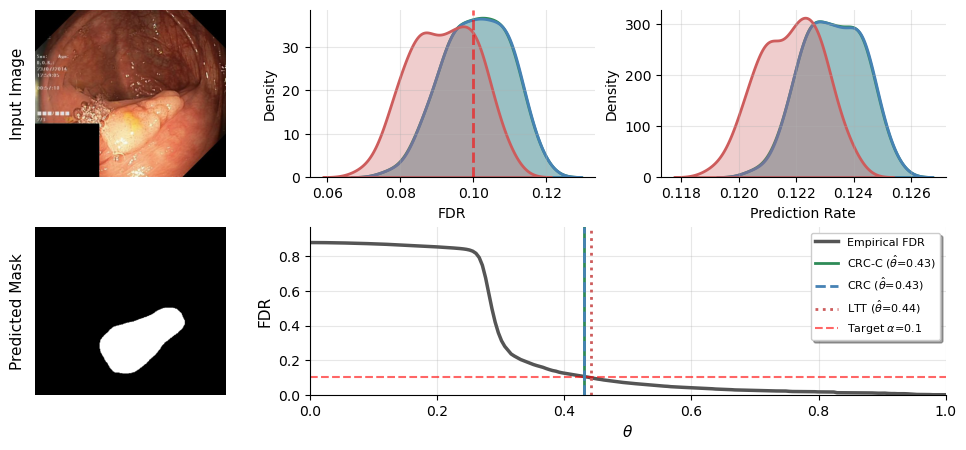

Master figure saved to ./plots/master-figure-fdr-segmentation.pdf


In [ ]:
# Master figure for paper
np.random.seed(42)

# Select example image
rand_idx = np.random.choice(example_indexes)
img = imread('../data/polyps/examples/' + str(rand_idx) + '.jpg')
gt_mask = imread('../data/polyps/examples/' + str(rand_idx) + '_gt_mask.jpg')
theta_final = results_conservative['theta_hat']
predicted_mask = resize(sgmd[rand_idx] >= theta_final, 
                       (img.shape[0], img.shape[1]), 
                       anti_aliasing=False)

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(2, 3, width_ratios=[0.8, 1, 1], height_ratios=[1, 1],
                      wspace=0.25, hspace=0.3)

# Left column: images with titles on the LEFT
ax_input = fig.add_subplot(gs[0, 0])
ax_input.imshow(img)
ax_input.axis('off')
ax_input.text(-0.05, 0.5, 'Input Image', transform=ax_input.transAxes, 
              fontsize=11, va='center', ha='right', rotation=90)

ax_pred = fig.add_subplot(gs[1, 0])
ax_pred.imshow(predicted_mask, cmap='gray')
ax_pred.axis('off')
ax_pred.text(-0.05, 0.5, 'Predicted Mask', transform=ax_pred.transAxes, 
             fontsize=11, va='center', ha='right', rotation=90)

# Top right: Two KDE plots side by side
ax_fdr_kde = fig.add_subplot(gs[0, 1])
sns.kdeplot(results_experiment['crc_c_fdr'], ax=ax_fdr_kde, label='CRC-C',
            color='#2E8B57', linewidth=2, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['crc_fdr'], ax=ax_fdr_kde, label='CRC',
            color='#4682B4', linewidth=2, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['ltt_fdr'], ax=ax_fdr_kde, label='LTT',
            color='#CD5C5C', linewidth=2, fill=True, alpha=0.3)
ax_fdr_kde.axvline(x=alpha, linewidth=2, linestyle='--', color='#888888', alpha=0.6)
ax_fdr_kde.set_xlabel('FDR', fontsize=10)
ax_fdr_kde.set_ylabel('Density', fontsize=10)
ax_fdr_kde.grid(True, alpha=0.3)
sns.despine(ax=ax_fdr_kde)

ax_pred_kde = fig.add_subplot(gs[0, 2])
sns.kdeplot(results_experiment['crc_c_pred_rate'], ax=ax_pred_kde, label='CRC-C',
            color='#2E8B57', linewidth=2, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['crc_pred_rate'], ax=ax_pred_kde, label='CRC',
            color='#4682B4', linewidth=2, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['ltt_pred_rate'], ax=ax_pred_kde, label='LTT',
            color='#CD5C5C', linewidth=2, fill=True, alpha=0.3)
ax_pred_kde.set_xlabel('Prediction Rate', fontsize=10)
ax_pred_kde.set_ylabel('Density', fontsize=10)
ax_pred_kde.grid(True, alpha=0.3)
sns.despine(ax=ax_pred_kde)

# Bottom right: FDR curve (spans columns 1-2)
ax_fdr = fig.add_subplot(gs[1, 1:])
ax_fdr.plot(thetas_viz, fdr_curve, label='Empirical FDR', linewidth=2.5, color='#555555')
ax_fdr.axvline(x=results_conservative['theta_hat'], linewidth=2, linestyle='-', 
               label=f"CRC-C ($\\hat{{\\theta}}$={results_conservative['theta_hat']:.2f})", color='#2E8B57')
ax_fdr.axvline(x=results_standard['theta_hat'], linewidth=2, linestyle='--', 
               label=f"CRC ($\\hat{{\\theta}}$={results_standard['theta_hat']:.2f})", color='#4682B4')
ax_fdr.axvline(x=results_ltt['theta_hat'], linewidth=2, linestyle=':', 
               label=f"LTT ($\\hat{{\\theta}}$={results_ltt['theta_hat']:.2f})", color='#CD5C5C')
ax_fdr.axhline(y=alpha, linewidth=1.5, linestyle='--', 
               label=f'Target $\\alpha$={alpha}', color='#888888', alpha=0.6)
ax_fdr.set_xlabel('$\\theta$', fontsize=11)
ax_fdr.set_ylabel('FDR', fontsize=11)
ax_fdr.legend(fontsize=8, loc='upper right', framealpha=1, shadow=True)
ax_fdr.set_xlim([0, 1])
ax_fdr.set_ylim([0, min(1.0, fdr_curve.max() * 1.1)])
ax_fdr.grid(True, alpha=0.3)
sns.despine(ax=ax_fdr)

os.makedirs('./plots', exist_ok=True)
plt.savefig('./plots/master-figure-fdr-segmentation.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("Master figure saved to ./plots/master-figure-fdr-segmentation.pdf")